# Amazon Electronic MLN Recommendation via PyTorch

adapted from https://github.com/fastai/fastai

In [41]:
import math
import copy
import os
import pickle
from pathlib import Path
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler

In [42]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

In [43]:
def read_data(path, filename='amazon-electronic-product-recommendation.csv', n=50):
    """ Read the amazon electronic dataset

    Parameters
    ----------
    path: path to csv
    filename: csv name
    n: min amount of ratings per user to keep

    Returns
    -------
    files: list of pd.Dataframes
    """
    files = {}
    path = Path(path)
    rating_info= pd.read_csv(os.path.join(path, filename), names=['user_id', 'item_id', 'rating', 'timestamp'])
    # count rating per user
    counts = rating_info['user_id'].value_counts()  # count ratings per user
    # only keep users with more than n ratings
    rating_info = rating_info[rating_info['user_id'].isin(counts[counts >= n].index)]
    return rating_info

In [44]:
# pick one of the available folders
ratings = read_data('/home/weiss/.dgl/electronic')

In [45]:
ratings.head()

,user_id,item_id,rating,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


In [46]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()

    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)

    unique_items = ratings.item_id.unique()
    item_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = ratings.item_id.map(item_to_index)

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_items})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_items), (X, y), (user_to_index, item_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} items')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 1540 users, 48190 items
Dataset shape: (125871, 2)
Target shape: (125871,)


In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}

In [48]:
class RatingsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [49]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in RatingsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [50]:
class RecommenderNet(nn.Module):
    """
    Creates dense MLN with embedding layers.

    Args:
        n_users:
            Number of unique users in the dataset.

        n_items:
            Number of unique items in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applied right after each of hidden layers.

    """
    def __init__(self, n_users, n_items,
                 n_factors=50, embedding_dropout=0.02,
                 hidden=10, dropouts=0.2):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_items, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self.relu = nn.ReLU()
        self._init()

    def forward(self, users, items, minmax=None):
        features = torch.cat([self.u(users), self.m(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        #out = self.relu(self.fc(x))  # relu delivers worse rsme
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """

        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [51]:
class CyclicLR(_LRScheduler):

    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [52]:
def cosine(t_max, eta_min=0):

    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    return scheduler

In [53]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)


In [54]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(1.0, 5.0)

In [55]:
net = RecommenderNet(
    n_users=n, n_items=m,
    n_factors=50, hidden=[100, 100],
    embedding_dropout=0.05, dropouts=[0.5, 0.5])

In [56]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 300
patience = 100
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [57]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/300] train: 1.4501 - val: 1.0653
loss improvement on epoch: 2
[002/300] train: 1.0126 - val: 1.0207
loss improvement on epoch: 3
[003/300] train: 0.8951 - val: 0.9952
[004/300] train: 0.7126 - val: 1.0138
[005/300] train: 0.6854 - val: 1.0616
[006/300] train: 0.5923 - val: 1.0683
[007/300] train: 0.6038 - val: 1.0791
[008/300] train: 0.5367 - val: 1.0906
[009/300] train: 0.5542 - val: 1.0881
[010/300] train: 0.4971 - val: 1.1081
[011/300] train: 0.5176 - val: 1.0984
[012/300] train: 0.4679 - val: 1.1196
[013/300] train: 0.4862 - val: 1.1166
[014/300] train: 0.4452 - val: 1.1292
[015/300] train: 0.4632 - val: 1.1309
[016/300] train: 0.4244 - val: 1.1441
[017/300] train: 0.4424 - val: 1.1541
[018/300] train: 0.4071 - val: 1.1704
[019/300] train: 0.4187 - val: 1.1724
[020/300] train: 0.3900 - val: 1.1909
[021/300] train: 0.4037 - val: 1.1818
[022/300] train: 0.3734 - val: 1.2060
[023/300] train: 0.3827 - val: 1.1930
[024/300] train: 0.3548 - val: 1.2207
[

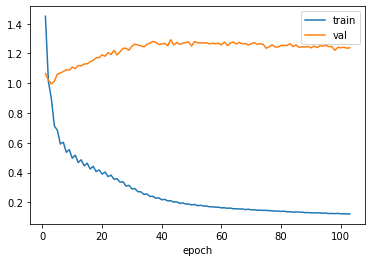

In [58]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

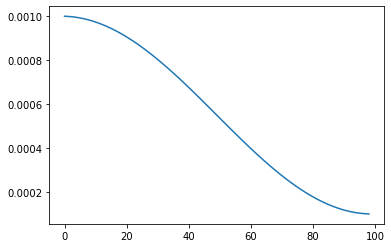

In [59]:
# Plot decreasing learning rate

_ = plt.plot(lr_history[:2*iterations_per_epoch-1])

In [60]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [61]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [62]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 1.0220


In [63]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [64]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 1.0040


In [65]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)